In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
from datetime import datetime, date
from sklearn.utils import shuffle
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
import PIL
from pathlib import Path
from tensorflow.keras.applications import VGG16, ResNet152, InceptionV3
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Init Plugin
Init Graph Optimizer
Init Kernel
Tensor Flow Version: 2.5.0
Keras Version: 2.5.0

Python 3.9.7 (default, Sep 16 2021, 23:53:23) 
[Clang 12.0.0 ]
Pandas 1.3.1
Scikit-Learn 0.24.2
GPU is available


In [96]:
tf.keras.utils.to_categorical(0, num_classes=2)

array([1., 0.], dtype=float32)

In [3]:
external_hdd_path = "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/windows/p4_dag3"
os.chdir(external_hdd_path)
eeg_img_path =  "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/windows/p4_dag3"
ecg_img_path = "/Users/niklashjort/Desktop/Notes/Speciale/projects/Dataset/windows/p4_dag3"
batch_size = 18

def get_img_input_shape(for_model=False):
    if for_model:
        return(299,299,3)
    return (299, 299)

In [2]:
external_hdd_path = "/Volumes/NHR HDD/Køge_02/"
os.chdir(external_hdd_path)
eeg_img_path =  "Windows/EEG/Images/"
ecg_img_path = "Windows/EKG/Images/"
batch_size = 18

def get_img_input_shape(for_model=False):
    if for_model:
        return(299,299,3)
    return (299, 299)


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/NHR HDD/Køge_02/'

In [119]:
def shuffle_order_dataframes(df_a, df_b):
    same_len = len(df_a) == len(df_b)
    if same_len:
        idx = np.random.permutation(df_a.index)
        df_a = df_a.reindex(idx, axis=0)
        df_b = df_b.reindex(idx, axis=0)
        print(df_a.head())
        print(df_b.head())
        return df_a, df_b
    print("not same len = not shuffled identically")
    return df_a, df_b

In [4]:
try:
    os.remove(eeg_img_path + "/.DS_Store")
except FileNotFoundError as e:
    print(f"file not found with error: {e}")

In [ ]:
# path = Path(train_path).rglob("*.png")
# for img_p in path:
#     try:
#         img = PIL.Image.open(img_p)
#     except PIL.UnidentifiedImageError:
#             print(f"FOUND NON VALID IMAGE | path : {img_p} ")

In [5]:
"EEG train path"
[print(f) for f in os.listdir(eeg_img_path)]

"ECG train path"
[print(f) for f in os.listdir(ecg_img_path)]


non-sz
sz
non-sz
sz


[None, None]

In [6]:
def inspect_class_distribution(path):
    dist_list = {}
    for i in os.listdir(path):
        classname = i
        number_of_png = str(len([x for x in os.listdir(path + "/" + i)]))
        #dict = {classname, number_of_png}
        dist_list[classname] =  number_of_png
    return dist_list

eeg_class_dist = inspect_class_distribution(eeg_img_path)
ecg_class_dist = inspect_class_distribution(ecg_img_path)

print(f"eeg distribution: {eeg_class_dist} \n ecg distribution: {ecg_class_dist}")

eeg distribution: {'non-sz': '366', 'sz': '183'} 
 ecg distribution: {'non-sz': '366', 'sz': '183'}


In [7]:
def get_lowest_distr(dict_a, dict_b):

    concat_dict = []
    concat_dict.append(dict_a)
    concat_dict.append(dict_b)
    min_val = 0

    for item in concat_dict:
        for key in item:
            try:
                item[key] = int(item[key])
            except ValueError:
                item[key] = float(item[key])
            if min_val == 0:
                min_val = item[key]
            elif item[key] < min_val:
                min_val = item[key]
    return int(min_val)

print(get_lowest_distr(eeg_class_dist, ecg_class_dist))
max_n_images = get_lowest_distr(ecg_class_dist, eeg_class_dist)

183


In [8]:
def limit_data(data_dir,n=max_n_images):
    a=[]
    for i in os.listdir(data_dir):
        image_path = random.sample(os.listdir(data_dir+'/'+i), max_n_images)
        for k,j in enumerate(image_path):
            if k>n:continue
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['filename','class']).reset_index(drop=True)

In [9]:
balanced_ecg_data = limit_data(ecg_img_path).sort_values(by=['class']).reset_index(drop=True)
balanced_eeg_data = limit_data(eeg_img_path).sort_values(by=['class']).reset_index(drop=True)

In [10]:
balanced_ecg_data['class'].value_counts()

non-sz    183
sz        183
Name: class, dtype: int64

In [11]:
balanced_eeg_data['class'].value_counts()

non-sz    183
sz        183
Name: class, dtype: int64

In [12]:
idx = np.random.permutation(balanced_eeg_data.index)

In [13]:
balanced_eeg_data = balanced_eeg_data.reindex(idx, axis=0)

In [14]:
balanced_eeg_data.head()

,filename,class
305,/Users/niklashjort/Desktop/Notes/Speciale/proj...,sz
133,/Users/niklashjort/Desktop/Notes/Speciale/proj...,non-sz
74,/Users/niklashjort/Desktop/Notes/Speciale/proj...,non-sz
299,/Users/niklashjort/Desktop/Notes/Speciale/proj...,sz
260,/Users/niklashjort/Desktop/Notes/Speciale/proj...,sz


In [15]:
balanced_ecg_data = balanced_ecg_data.reindex(idx, axis=0)

In [16]:
balanced_ecg_data.head()

,filename,class
305,/Users/niklashjort/Desktop/Notes/Speciale/proj...,sz
133,/Users/niklashjort/Desktop/Notes/Speciale/proj...,non-sz
74,/Users/niklashjort/Desktop/Notes/Speciale/proj...,non-sz
299,/Users/niklashjort/Desktop/Notes/Speciale/proj...,sz
260,/Users/niklashjort/Desktop/Notes/Speciale/proj...,sz


In [ ]:
def get_new_df():
    

In [121]:
class custom_generator(tf.keras.utils.Sequence):
    def __init__(self, ecg_path, eeg_path, batch_size, img_shape, shuffle=True, X_col='filename', Y_col='class'):
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.shuffle = shuffle
        self.X_col = X_col
        self.Y_col = Y_col
        self.class_mapping = {"sz": 1, "non-sz": 0}
        self.ecg_path = ecg_path
        self.eeg_path = eeg_path
        self.eeg_df, self.ecg_df = self.__generate_data()
        self.len = len(self.eeg_df)
        self.n_name = self.ecg_df[self.Y_col].nunique()

    def __generate_data(self):
        eeg_class_dist = inspect_class_distribution(self.eeg_path)
        ecg_class_dist = inspect_class_distribution(self.ecg_path)
        max_n_images = get_lowest_distr(ecg_class_dist, eeg_class_dist)
        balanced_ecg_data = limit_data(self.ecg_path, max_n_images).sort_values(by=[self.Y_col]).reset_index(drop=True)
        balanced_eeg_data = limit_data(self.eeg_path, max_n_images).sort_values(by=[self.Y_col]).reset_index(drop=True)
        return shuffle_order_dataframes(balanced_eeg_data, balanced_ecg_data)

    def on_epoch_end(self):
        if shuffle:
            self.ecg_df, self.eeg_df = self.__generate_data()
            

    def __get_input(self, path, target_size):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()

        return image_arr/255.

    def __get_output(self, label, num_classes):
        categoric_label = self.class_mapping[label]
        return tf.keras.utils.to_categorical(categoric_label, num_classes=num_classes)

    def __get_data(self, x1_batches):
        eeg_path_batch = x1_batches[self.X_col]
        ecg_path_batch = x1_batches[self.X_col]

        label_batch = x1_batches[self.Y_col]

        x1_batch = np.asarray([self.__get_input(x, self.img_shape) for x in eeg_path_batch])
        x2_batch = np.asarray([self.__get_input(x, self.img_shape) for x in ecg_path_batch])
        y_batch = np.asarray([self.__get_output(y, self.n_name) for y in label_batch])

        return tuple([x1_batch, x2_batch]), y_batch

    def __getitem__(self, index):
        n_batches = self.eeg_df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(n_batches)        
        return X, y

    def __len__(self):
        return self.len // self.batch_size

In [122]:
train_gen = custom_generator(ecg_img_path, eeg_img_path, 10, img_shape=(299,299,3))

                                              filename   class
81   /Users/niklashjort/Desktop/Notes/Speciale/proj...  non-sz
178  /Users/niklashjort/Desktop/Notes/Speciale/proj...  non-sz
182  /Users/niklashjort/Desktop/Notes/Speciale/proj...  non-sz
319  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
295  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
                                              filename   class
81   /Users/niklashjort/Desktop/Notes/Speciale/proj...  non-sz
178  /Users/niklashjort/Desktop/Notes/Speciale/proj...  non-sz
182  /Users/niklashjort/Desktop/Notes/Speciale/proj...  non-sz
319  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
295  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz


In [123]:
train_gen.n_name

2

In [124]:
X, y= train_gen[0]

In [125]:
X

(array([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         ...,
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
 
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]],
 
 
        [

In [126]:
def create_covn_layers(input_layer):
    input = layers.Conv2D(32, (3,3), padding='same', input_shape=get_img_input_shape(True))(input_layer)
    covn01 = layers.Conv2D(32, (3, 3))(input)
    acti01 = layers.Activation('relu')(covn01)
    pool01 = layers.MaxPooling2D((2, 2))(acti01)
    covn02 = layers.Conv2D(64, (3, 3))(pool01)
    acti02 = layers.Activation('relu')(covn02)
    pool02 = layers.MaxPooling2D(2, 2)(acti02)
    covn03 = layers.Conv2D(128, (3, 3))(pool02)
    acti03 = layers.Activation('relu')(covn03)
    pool03 = layers.MaxPooling2D(pool_size=(2,2), padding='same')(acti03)
    covn_base = layers.Dropout(0.2)(pool03)

    return covn_base



#flat = layers.Flatten()(pool03)
model_one_input = layers.Input(shape=get_img_input_shape(True))
model_one = create_covn_layers(model_one_input)

model_two_input = layers.Input(shape=get_img_input_shape(True))
model_two = create_covn_layers(model_two_input)


In [127]:
concat_feature_layer = layers.concatenate([model_one, model_two])
flatten_layer = layers.Flatten()(concat_feature_layer)
fully_connected_dense_big = layers.Dense(256, activation='relu')(flatten_layer)
dropout_one = layers.Dropout(0.3)(fully_connected_dense_big)
fully_connected_dense_small = layers.Dense(128, activation='relu')(dropout_one)
dropout_two = layers.Dropout(0.3)(fully_connected_dense_small)
output = layers.Dense(2, activation='softmax')(dropout_two)

model = Model(
    inputs=[model_one_input, model_two_input],
    outputs=output
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 299, 299, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 299, 299, 32) 896         input_4[0][0]                    
____________________________________________________________________________________________

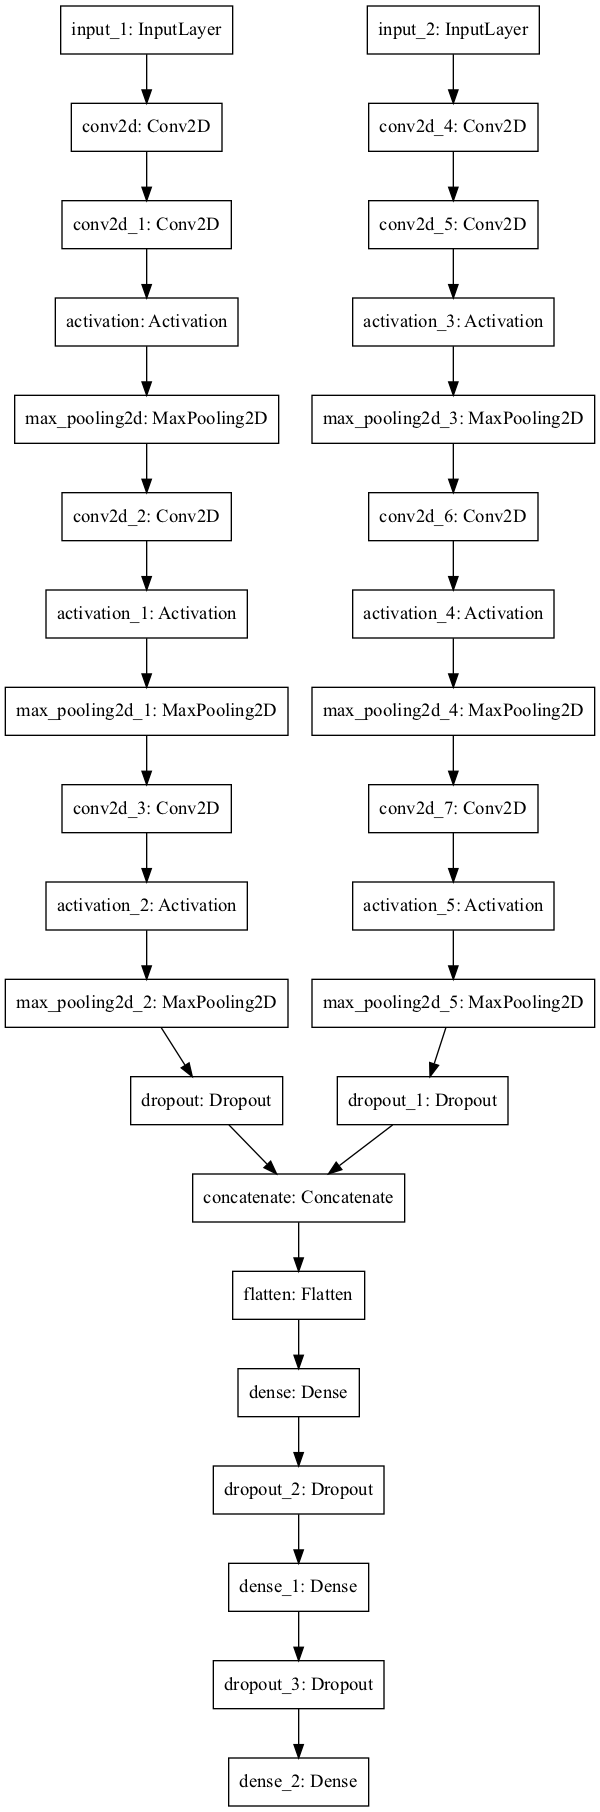

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [128]:
opt = Adam()

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=[tensorflow.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
train_generator_one = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)

# train_generator_two = ImageDataGenerator(
# rescale = 1./255, 
# validation_split=0.2
# )

input_1_train_gen = train_generator_one.flow_from_dataframe(
    balanced_eeg_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="training")

input_2_train_gen = train_generator_one.flow_from_dataframe(
    balanced_ecg_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="training")

input_1_validation_gen = train_generator_one.flow_from_dataframe(
    balanced_eeg_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation")


input_2_validation_gen = train_generator_one.flow_from_dataframe(
    balanced_ecg_data,
    batch_size=batch_size, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation")



Found 3399 validated image filenames belonging to 3 classes.
Found 3399 validated image filenames belonging to 3 classes.
Found 849 validated image filenames belonging to 3 classes.
Found 849 validated image filenames belonging to 3 classes.


In [ ]:
def create_data_generator(data_gen_one, data_gen_two):

    while(True):
        _gen1, _gen1_l = next(data_gen_one)
        _gen2, _gen2_l = next(data_gen_two)

        yield [_gen1, _gen2], np.array(_gen1_l)

multi_train_generator = create_data_generator(
    input_1_train_gen,
    input_2_train_gen
    )

multi_validation_generator = create_data_generator(
    input_1_validation_gen,
    input_2_validation_gen
    )

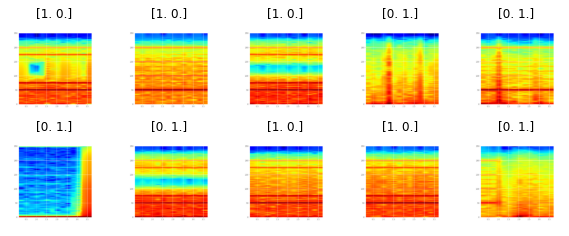

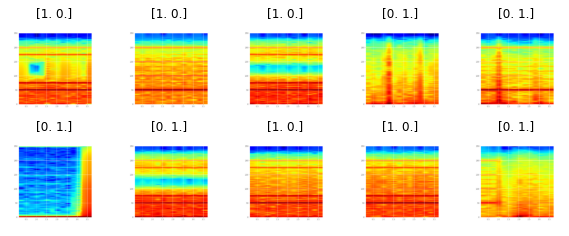

In [129]:
def show_batch(image, label):
  plt.figure(figsize=(10,10))
  for n in range(10):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image[n])
      plt.title(label[n])
      plt.axis('off')

image, label = train_gen[0]
show_batch(image[0], label)

show_batch(image[1], label)

In [ ]:
label[0]

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
x = 120
input_1_validation_gen.classes[x:x+10]

[1, 1, 2, 1, 1, 2, 1, 0, 1, 0]

In [ ]:
class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()


import numpy as np
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

ImportError: cannot import name 'LayerNormalization' from 'keras.layers.normalization' (/usr/local/Caskroom/miniforge/base/envs/speciale_01_01/lib/python3.9/site-packages/keras/layers/normalization/__init__.py)

In [84]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=7, min_lr=0.00001)

In [83]:
class TestCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x = self.test_data
        loss, acc = self.model.evaluate(x, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

In [85]:
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath="Shallow_checkpoint.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [130]:
history = model.fit(
    train_gen,
    epochs=20
)

Epoch 1/20


2021-12-07 15:46:00.661463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 35s 955ms/step - loss: 1.7851 - categorical_accuracy: 0.6056
                                              filename   class
39   /Users/niklashjort/Desktop/Notes/Speciale/proj...  non-sz
230  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
316  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
192  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
294  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
                                              filename   class
39   /Users/niklashjort/Desktop/Notes/Speciale/proj...  non-sz
230  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
316  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
192  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
294  /Users/niklashjort/Desktop/Notes/Speciale/proj...      sz
Epoch 2/20
36/36 [==============================] - 34s 956ms/step - loss: 0.6033 - categorical_accuracy: 0.7056
                             

KeyboardInterrupt: 

In [ ]:
history_dict = history.history
print(history_dict.keys())


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [ ]:
model.save("inceptionv3_100epoch_windows02.h5")

In [ ]:
with open('history.txt', 'a') as f:
    f.write(str(datetime.now()) + "\n" + str(history.history) +"\n")
    f.close()

In [ ]:
print(history.history['val_categorical_accuracy'])

[0.5177304744720459]


<Figure size 216x288 with 0 Axes>

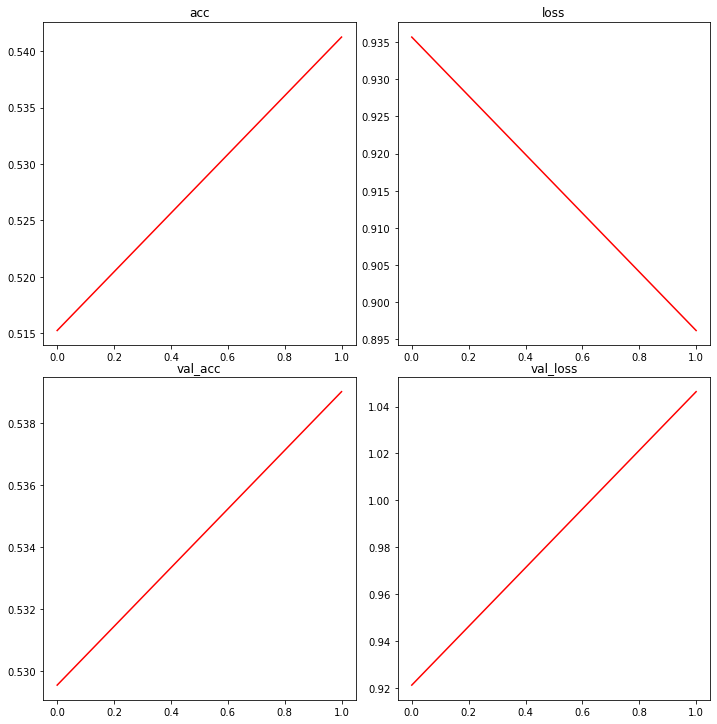

In [ ]:
plt.figure(figsize=(3,4))
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.tight_layout()
axs[0,0].set_title('acc')
axs[0,0].plot(history.history['categorical_accuracy'], color='red')
axs[0,1].set_title('loss')
axs[0,1].plot(history.history['loss'], color='red')
axs[1,0].set_title('val_acc')
axs[1,0].plot(history.history['val_categorical_accuracy'], color='red')
axs[1,1].set_title('val_loss')
axs[1,1].plot(history.history['val_loss'], color='red')
plt.savefig(f"{date.today()}_history_metrics_eval.png")

<Figure size 216x288 with 0 Axes>

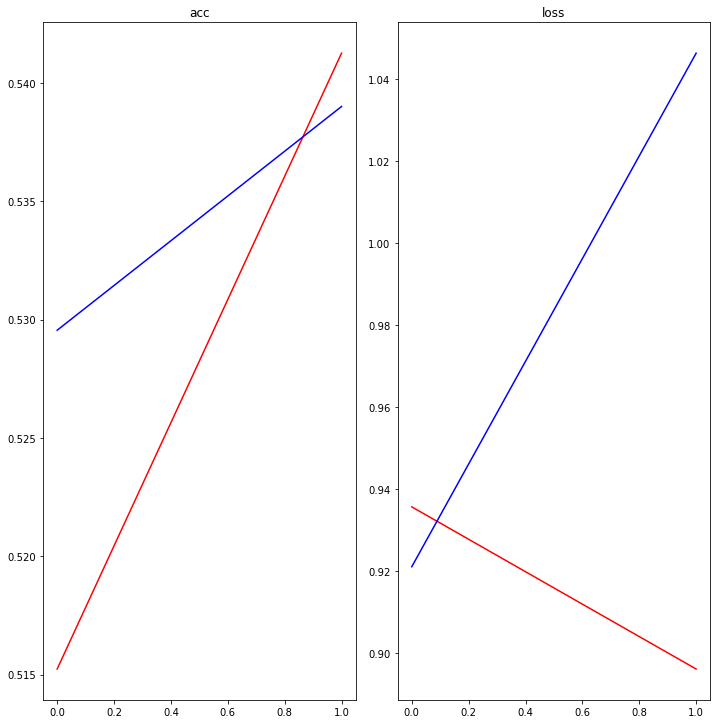

In [ ]:
plt.figure(figsize=(3,4))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
plt.tight_layout()
ax1.set_title('acc')
ax1.plot(history.history['categorical_accuracy'], color='red')
ax1.plot(history.history['val_categorical_accuracy'], color='blue')

ax2.set_title('loss')
ax2.plot(history.history['loss'], color='red')
ax2.plot(history.history['val_loss'], color='blue')
plt.savefig(f"{date.today()}_history_compare.png")

In [ ]:
input_eeg_test_gen = train_generator_one.flow_from_dataframe(
    balanced_eeg_data,
    batch_size=1, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation")

input_ecg_test_gen = train_generator_one.flow_from_dataframe(
    balanced_ecg_data,
    batch_size=1, 
    target_size=get_img_input_shape(), 
    shuffle=False,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation")

multi_test_generator = create_data_generator(
    input_eeg_test_gen,
    input_ecg_test_gen
    )

Found 849 validated image filenames belonging to 3 classes.
Found 849 validated image filenames belonging to 3 classes.


In [ ]:
number_of_step = input_ecg_test_gen.samples // 1
number_of_step

849

In [ ]:
pred = model.predict(multi_test_generator, steps=number_of_step)

2021-11-22 16:53:02.145886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
y_pred_max = pred.argmax(axis=-1)

In [ ]:
y_true = input_eeg_test_gen.classes

In [ ]:
for i, x in enumerate(input_eeg_test_gen.classes[0:6]):
    filename = input_eeg_test_gen.filenames[i]
    print(f"index : {i}, y_true : {x} : filename : {filename}")

for i, x in enumerate(input_ecg_test_gen.classes[0:6]):
    filename = input_ecg_test_gen.filenames[i]
    print(f"index : {i}, y_true : {x} : filename : {filename}")

index : 0, y_true : 0 : filename : Windows/EEG/Images//Interictal/21_6628_CH-2_07-58-58.png
index : 1, y_true : 2 : filename : Windows/EEG/Images//Seizure/21_97_Fp1-Ref_00-10-14.png
index : 2, y_true : 1 : filename : Windows/EEG/Images//Preictal/21_1243_Fp1-Ref_00-06-14.png
index : 3, y_true : 0 : filename : Windows/EEG/Images//Interictal/21_9145_Fp1-Ref_04-10-26.png
index : 4, y_true : 1 : filename : Windows/EEG/Images//Preictal/28_93_Fp2-Ref_07-59-07.png
index : 5, y_true : 2 : filename : Windows/EEG/Images//Seizure/4_49_CH-2_09-43-58.png
index : 0, y_true : 0 : filename : Windows/EKG/Images//Interictal/21_1829_ECG_00-34-17.png
index : 1, y_true : 2 : filename : Windows/EKG/Images//Seizure/21_203_ECG_23-42-46.png
index : 2, y_true : 1 : filename : Windows/EKG/Images//Preictal/21_140_ECG_23-55-41.png
index : 3, y_true : 0 : filename : Windows/EKG/Images//Interictal/35_2600_ECG_15-09-52.png
index : 4, y_true : 1 : filename : Windows/EKG/Images//Preictal/24_97_ECG_20-46-58.png
index : 5

In [ ]:
labels = ['Interictal', 'Preictal', 'Seizure']

In [ ]:
clf_report = classification_report(y_true=y_true, y_pred=y_pred_max, target_names=labels)

In [ ]:
print(clf_report)

              precision    recall  f1-score   support

  Interictal       0.42      0.46      0.44       269
    Preictal       0.63      0.34      0.44       298
     Seizure       0.59      0.83      0.69       282

    accuracy                           0.54       849
   macro avg       0.55      0.54      0.52       849
weighted avg       0.55      0.54      0.52       849



In [ ]:
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=list(y_pred_max), normalize='all')

confusion_matrix

array([[0.14487633, 0.06595995, 0.10600707],
       [0.14605418, 0.12014134, 0.08480565],
       [0.05418139, 0.00353357, 0.27444052]])

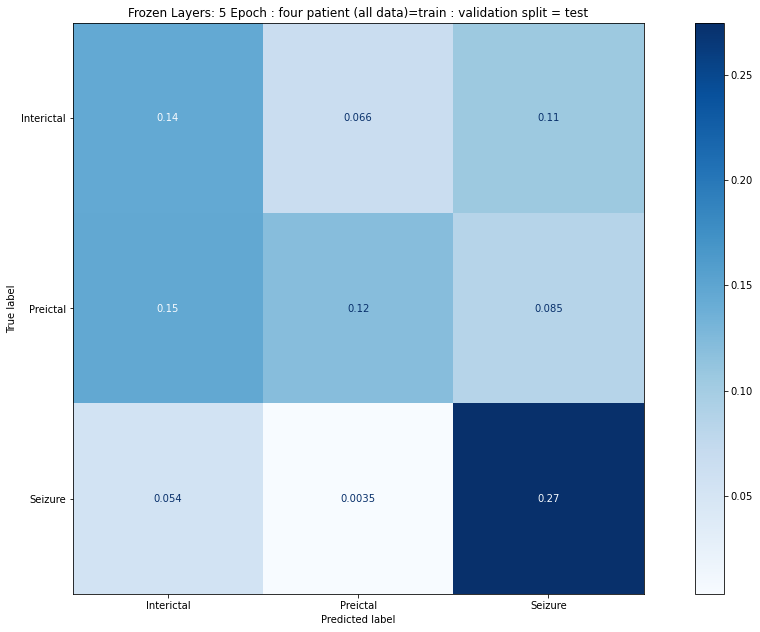

In [ ]:
import matplotlib
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels).plot(cmap='Blues')
plt.title("Frozen Layers: 5 Epoch : four patient (all data)=train : validation split = test")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig(f"{date.today}_confus_matrix.png")